<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/0_DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA_and_Cleaning.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

## Allgemeine Einstellungen:

In [1]:
# Installation der pvlib um den Sonnenstandswinkel zu berechnen
pip install pvlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 39.7 MB/s eta 0:00:00


In deiesem Notebook werden die aufgezeichenten UVI-Messungen weiter verarbeitet und für das Training vorbereitet.


- Einlesen der UVI-Werte
- Ersetzen von fehlenden Messwerten

- Einlesen der weiteren Inputwerte
- EDA (exploratory data analysis)

In [2]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import der benötigten Module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvlib

from datetime import datetime
from datetime import timedelta

import matplotlib
import seaborn as sns

In [4]:
# Standort der Messstaion für die Berechnung des Sonnenstandswinkel
latitude = 50.8
longitude = 7.2

# Angaben um das Datum und die Uhrzeit in Sin und Cos zu codieren
seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [5]:
# Pfad zu den Messwerten / Vorhersagewerten und dem Speicherort auf Google Drive
drive_path = '/content/drive/My Drive/Colab_Notebooks/CSV_UVI/'
pickle_path = '/content/drive/My Drive/Colab_Notebooks/CAMS_Vorhersage/'
save_folder = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

## Import der UVI-Messdaten:

Die Messdaten sind in CSV-Dateien gespeichert, diese müssen importiert werden.

In [6]:
## Code zum Import der Messdaten
file_list = ['22.06', '22.07', '22.08', '22.09', '22.10', '22.11', '22.12', '23.01', '23.02', '23.03', '23.04', '23.05', '23.07', '23.08']  # Hier wird angegeben, welche Monate importiert werden sollen
dataframes = []
df_UVI_combined = []

for filename in file_list:
    file_path = drive_path + filename
    df_import = pd.read_csv(file_path)
    dataframes.append(df_import)

df_UVI_combined = pd.concat(dataframes, ignore_index=True)
df_UVI_combined['Datetime'] = pd.to_datetime(df_UVI_combined['Datetime'])

In [7]:
# Dataframe ausgeben
df_UVI_combined.fillna(0)

,Messzeitpunkt,Uhrzeit,Datum,Datetime,erythem,UVI
0,26460,07:21:00,2022-06-15,2022-06-15 07:21:00,0.060209,2.408378
1,26580,07:23:00,2022-06-15,2022-06-15 07:23:00,0.061560,2.462381
2,26700,07:25:00,2022-06-15,2022-06-15 07:25:00,0.061976,2.479048
3,26820,07:27:00,2022-06-15,2022-06-15 07:27:00,0.063588,2.543531
4,26940,07:29:00,2022-06-15,2022-06-15 07:29:00,0.064412,2.576485
...,...,...,...,...,...,...
107933,32640,09:04:00,2023-05-26,2023-05-26 09:04:00,0.117537,4.701465
107934,32760,09:06:00,2023-05-26,2023-05-26 09:06:00,0.118624,4.744953
107935,32880,09:08:00,2023-05-26,2023-05-26 09:08:00,0.094757,3.790279
107936,33000,09:10:00,2023-05-26,2023-05-26 09:10:00,0.000000,0.000000


## Bereinigen der Messdaten

Hier wird erklärt, was zum Bereinigen der Messdaten getan werden muss.

- Fehlende Messtage müssen ersetzt werden:
  - Prüfen, ob die Messwerte zusammenhängen.
  - Hinzufügen neuer Zeilen, falls die Messwerte nicht zusammen Hängen.

**Hier wird geprüft, ob die Messwerte zusammenhängend sind:**

In [8]:
def insert_missing_rows(df):
    # Sortieren des DataFrame nach 'Datetime'
    df.sort_values(by='Datetime', inplace=True)

    # Initialisieren einer Liste, um die Zeilen mit fehlenden Daten einzufügen
    rows_to_insert = []

    # Gruppieren des DataFrame nach 'Datum'
    grouped = df.groupby('Datum')

    for date, group in grouped:
        # Sortieren der Gruppe nach 'Datetime'
        group.sort_values(by='Datetime', inplace=True)

        for i in range(1, len(group)):
            current_time = group.iloc[i]['Datetime']
            prev_time = group.iloc[i - 1]['Datetime']
            time_diff = current_time - prev_time

            if time_diff > timedelta(minutes=2):
                while prev_time + timedelta(minutes=2) < current_time:
                    prev_time += timedelta(minutes=2)
                    new_row = {
                        'Datetime': prev_time,
                        'Datum': date,
                        'Uhrzeit': prev_time.time(),
                        'Messzeitpunkt': (prev_time - prev_time.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds(),
                        'erythem': 0,
                        'UVI': 0,
                        'DiffGreater2': 1,
                    }
                    rows_to_insert.append(new_row)

    # Einfügen der fehlenden Zeilen in einen DataFrame
    if rows_to_insert:
        df = df.append(rows_to_insert, ignore_index=True)

    # Sortieren des DataFrame nach 'Datetime'
    df.sort_values(by='Datetime', inplace=True)
    df = df.reset_index(drop = True)
    df['DiffGreater2'] = df['DiffGreater2'].fillna(0)

    return df

In [9]:
df_UVI_WRows = pd.DataFrame()
df_UVI_WRows = insert_missing_rows(df_UVI_combined)

<ipython-input-8-a09571970f8b>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(rows_to_insert, ignore_index=True)


## Sonnenstandswinkel hinzufügen

In [10]:
def calculate_solar_zenith_angle(dataframe, date_column, latitude, longitude, altitude=0):

    # Kopiere das ursprüngliche DataFrame, um es nicht zu ändern.
    result_df = dataframe.copy()

    # Konvertiere die Datumsspalte in einen datetime-Datentyp, falls sie es nicht bereits ist.
    if not pd.api.types.is_datetime64_any_dtype(dataframe[date_column]):
        result_df[date_column] = pd.to_datetime(dataframe[date_column])

    # Iteriere über die Zeilen des DataFrames und berechne den Solarzenitwinkel für jedes Datum.
    solar_zenith_angles = []
    for date in result_df[date_column]:
        solar_position = pvlib.solarposition.get_solarposition(date, latitude, longitude, altitude)
        solar_zenith_angle = solar_position['zenith'].values[0]
        solar_zenith_angles.append(solar_zenith_angle)

    # Füge die berechneten Solarzenitwinkel dem DataFrame hinzu.
    result_df['SZA'] = solar_zenith_angles

    return result_df

In [11]:
df_UVI_WRows_SZ = pd.DataFrame()
df_UVI_WRows_SZ = calculate_solar_zenith_angle(df_UVI_WRows, 'Datetime', latitude, longitude)

## Zeit und Datum in Sin und Cos codieren
- Cyclical Encoding der Messzeit als Sinus und Cosinus

In [12]:
def calculate_date_in_sine_cosine(dataframe, day, year):

    result_df = dataframe.copy()

    result_df['time_sin'] = np.sin(2*np.pi*result_df['Messzeitpunkt']/day)
    result_df['time_cos'] = np.cos(2*np.pi*result_df['Messzeitpunkt']/day)
    result_df['date_sin'] = np.sin((2*np.pi*result_df['Datetime'].dt.dayofyear * 24 * 60 * 60 + result_df['Datetime'].dt.hour * 60 * 60 + result_df['Datetime'].dt.minute * 60) / year)
    result_df['date_cos'] = np.cos((2*np.pi*result_df['Datetime'].dt.dayofyear * 24 * 60 * 60 + result_df['Datetime'].dt.hour * 60 * 60 + result_df['Datetime'].dt.minute * 60) / year)

    return result_df

In [13]:
df_UVI_SZ_SC = calculate_date_in_sine_cosine(df_UVI_WRows_SZ, seconds_in_day, seconds_in_year)

## Erstellen einer Liste mit Stunden an denen es Messwerte gibt:

In [14]:
# Herausschreiben des Datums und der Stunde aus den Messdaten um im Folgeden nur die relevanten Vorhersagedaten auszuwählen
df_UVI_SZ_SC['Date'] = df_UVI_SZ_SC['Datetime'].dt.date
df_UVI_SZ_SC['Hour'] = df_UVI_SZ_SC['Datetime'].dt.hour

In [15]:
df_date_std = df_UVI_SZ_SC.groupby(['Date', 'Hour']).size().reset_index(name='Count')

In [16]:
df_date_std['Datetime'] = pd.to_datetime(df_date_std['Date'].astype(str) + ' ' + df_date_std['Hour'].astype(str) + ':00:00')

In [17]:
df_date_std.set_index('Datetime', inplace=True)

## Import der Vorhersagedaten und löschen nicht gebrauchter Einträge:

In [18]:
dateiname = 'CSV_Cams_std'
df_cams_std = pd.read_csv(pickle_path + dateiname)
df_cams_std['Datetime'] = pd.to_datetime(df_cams_std['Datetime'])

In [19]:
# Datetime als Index festlegen
df_cams_std.set_index('Datetime', inplace=True)

In [20]:
# Löschen aller nicht relevanten Einträge
df_cams_std = df_cams_std[df_cams_std.index.isin(df_date_std.index)]

## Abspeichern des DataFrames als CSV

In [21]:
df_UVI_SZ_SC.isnull().sum()

Messzeitpunkt    0
Uhrzeit          0
Datum            0
Datetime         0
erythem          2
UVI              2
DiffGreater2     0
SZA              0
time_sin         0
time_cos         0
date_sin         0
date_cos         0
Date             0
Hour             0
dtype: int64

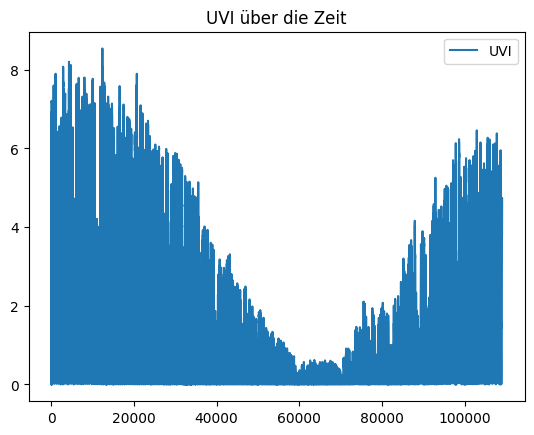

In [22]:
# Irradiance metrics over time
df_UVI_SZ_SC[['UVI']].plot()
plt.title('UVI über die Zeit');

In [23]:
def export_dataframes_to_csv(df1, df2, file1_name, file2_name, folder_name):

    try:
        # Exportiere den ersten DataFrame in eine CSV-Datei
        df1.to_csv(folder_name + file1_name)
        print(f'DataFrame 1 wurde erfolgreich in "{file1_name}" exportiert.')

        # Exportiere den zweiten DataFrame in eine CSV-Datei
        df2.to_csv(folder_name + file2_name)
        print(f'DataFrame 2 wurde erfolgreich in "{file2_name}" exportiert.')

    except Exception as e:
        print(f'Fehler beim Export der DataFrames: {str(e)}')

In [24]:
export_dataframes_to_csv(df_UVI_SZ_SC, df_cams_std, 'Messdaten.csv', 'Vorhersage.csv', save_folder)

DataFrame 1 wurde erfolgreich in "Messdaten.csv" exportiert.
DataFrame 2 wurde erfolgreich in "Vorhersage.csv" exportiert.
